### Example of a multivariate LSTM forecasting
Example of multivariate forecasting based on the tutorial in https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn import preprocessing
from numpy import concatenate
from math import sqrt
from keras.layers.wrappers import Bidirectional # new! 

ModuleNotFoundError: No module named 'keras'

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('datasets/beijing-pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)


In [3]:
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)


In [4]:
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


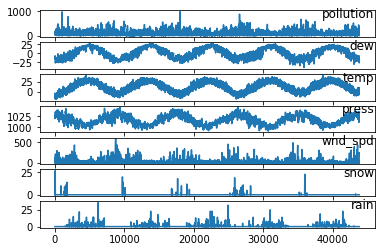

In [5]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
values=dataset.values
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#before transformation

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [8]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [9]:
x=pd.Series([1,2,3,4,5,6])
x.shift(-1)

0    2.0
1    3.0
2    4.0
3    5.0
4    6.0
5    NaN
dtype: float64

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [11]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [12]:
#print the fist two 'rows' of the rtaining dataset
train_X[:2]

array([[[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00229001, 0.        , 0.        ]],

       [[0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00381099, 0.        , 0.        ]]], dtype=float32)

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
drop_lstm=0.3
# design network
model = Sequential()
model.add(Bidirectional(LSTM(256,dropout=drop_lstm), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 512)               542720    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 543,233
Trainable params: 543,233
Non-trainable params: 0
_________________________________________________________________
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 [==============================] - 4s - loss: 0.0513 - val_loss: 0.0288
Epoch 2/50
8760/8760 [==============================] - 3s - loss: 0.0367 - val_loss: 0.0225
Epoch 3/50
8760/8760 [==============================] - 3s - loss: 0.0356 - val_loss: 0.0232
Epoch 4/50
8760/8760 [==============================] - 3s - loss: 0.0362 - val_loss: 0.0233
Epoch 5/50
8760/8760 [==============================] - 3s - loss: 0.0347 - val_loss: 0.0243
Epoch 6/50
8760/87

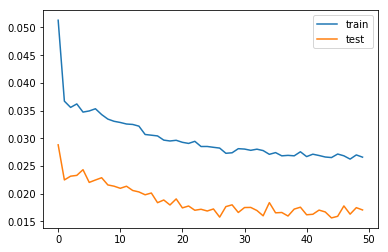

In [15]:
# plot history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


Test RMSE: 30.043


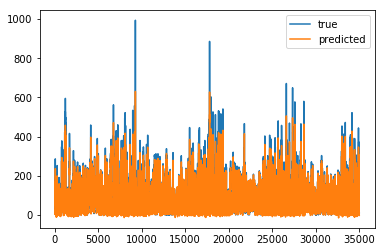

In [17]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# plot history
plt.figure(0)
plt.plot(inv_y, label='true')
plt.plot(inv_yhat, label='predicted')
plt.legend()
plt.show()

In [27]:
import numpy as np
x=np.array([1,2,3,4,5,6])
#print(x.shape)
#print(x.reshape(3,2))
print(x.reshape(1,3,2))
print(x.reshape(1,6,1))
print(x.reshape(3,2,1))

[[[1 2]
  [3 4]
  [5 6]]]
[[[1]
  [2]
  [3]
  [4]
  [5]
  [6]]]
[[[1]
  [2]]

 [[3]
  [4]]

 [[5]
  [6]]]
